In [1]:
import numpy as np
import pandas as pd

import random
random.seed(28)
np.random.seed(28)


import matplotlib.pyplot as plt
from sklearn.metrics import (confusion_matrix, precision_recall_curve, auc,
                             roc_curve, recall_score, classification_report, f1_score,
                             precision_recall_fscore_support)
import os
import copy
from sklearn.metrics import mean_absolute_error
pd.options.display.precision = 15
from collections import defaultdict
import lightgbm as lgb
import xgboost as xgb
#import catboost as cat
import time
from collections import Counter
import datetime
#from catboost import CatBoostRegressor
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold, KFold, RepeatedKFold, GroupKFold, GridSearchCV, train_test_split, TimeSeriesSplit, RepeatedStratifiedKFold
from sklearn import metrics
import gc
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
from bayes_opt import BayesianOptimization
#import eli5
#import shap
from IPython.display import HTML
import json

import matplotlib.pyplot as plt
%matplotlib inline
import os
import time
import datetime
import gc
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import metrics
pd.set_option('max_rows', 500)
import re

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

pd.set_option('display.max_columns', 1000)
np.random.seed(566)
pd.set_option('display.max_rows', 500)
pd.set_option('display.width', 1000)
pd.set_option('display.float_format', '{:20,.2f}'.format)
pd.set_option('display.max_colwidth', -1)

In [2]:
train=pd.read_csv('../data/training_v2.csv')
test=pd.read_csv('../data/unlabeled.csv')

In [3]:
## According to part 1 EDA, I would like to remove readmission_status
## And replace -1 with nan in both apache_4a_hospital_death_prob and apache_4a_icu_death_prob
train=train.drop(['readmission_status'], axis=1 )
train['apache_4a_hospital_death_prob']=train['apache_4a_hospital_death_prob'].replace(-1, np.nan)
train['apache_4a_icu_death_prob']=train['apache_4a_icu_death_prob'].replace(-1, np.nan)

test=test.drop(['readmission_status'], axis=1 )
test['apache_4a_hospital_death_prob']=test['apache_4a_hospital_death_prob'].replace(-1, np.nan)
test['apache_4a_icu_death_prob']=test['apache_4a_icu_death_prob'].replace(-1, np.nan)

In [4]:
## Acoording to part 2 adviral feature selection, I would like to remove hospital_id, icu_id and icu_type
train=train.drop(['hospital_id','icu_type','icu_id'], axis=1 )

test=test.drop(['hospital_id','icu_type','icu_id'], axis=1 )

In [5]:
train['hospital_admit_source'] = train['hospital_admit_source'].replace({'Other ICU': 'ICU','ICU to SDU':'SDU', 
                                                                         'Step-Down Unit (SDU)': 'SDU',
                                                                         'Other Hospital':'Other',
                                                                         'Observation': 'Recovery Room',
                                                                         'Acute Care/Floor': 'Acute Care'})

train['apache_2_bodysystem'] = train['apache_2_bodysystem'].replace({'Undefined diagnoses': 'Undefined Diagnoses'})

# test
test['hospital_admit_source'] = test['hospital_admit_source'].replace({'Other ICU': 'ICU','ICU to SDU':'SDU', 
                                                                         'Step-Down Unit (SDU)': 'SDU',
                                                                         'Other Hospital':'Other',
                                                                         'Observation': 'Recovery Room',
                                                                         'Acute Care/Floor': 'Acute Care'})

test['apache_2_bodysystem'] = test['apache_2_bodysystem'].replace({'Undefined diagnoses': 'Undefined Diagnoses'})

In [6]:
train_NA=pd.DataFrame(train.isna().sum(), columns=['Count'])
train_NA['% Missing']=100*(train_NA.Count/len(train))
train_NA.sort_values(by = ['% Missing'], ascending = False, na_position = 'first')

,Count,% Missing
h1_bilirubin_min,84619,92.27
h1_bilirubin_max,84619,92.27
h1_lactate_max,84369,91.99
h1_lactate_min,84369,91.99
h1_albumin_max,83824,91.40
h1_albumin_min,83824,91.40
h1_pao2fio2ratio_min,80195,87.44
h1_pao2fio2ratio_max,80195,87.44
h1_arterial_ph_min,76424,83.33
h1_arterial_ph_max,76424,83.33


In [7]:
test_=test.copy().drop('hospital_death', axis=1)
test_NA=pd.DataFrame(test_.isna().sum(), columns=['Count'])
test_NA['% Missing']=100*(test_NA.Count/len(test))
test_NA.sort_values(by = ['% Missing'], ascending = False, na_position = 'first')

,Count,% Missing
h1_bilirubin_max,36054,91.72
h1_bilirubin_min,36054,91.72
h1_albumin_max,35984,91.54
h1_albumin_min,35984,91.54
h1_lactate_max,34890,88.76
h1_lactate_min,34890,88.76
h1_pao2fio2ratio_min,33986,86.46
h1_pao2fio2ratio_max,33986,86.46
h1_arterial_pco2_max,32463,82.59
h1_arterial_pco2_min,32463,82.59


In [8]:
train_ls=list(train_NA[train_NA['% Missing']>80].index)
test_ls=list(test_NA[test_NA['% Missing']>80].index)

In [9]:
len(train_ls)

34

In [10]:
train=train.drop(train_ls, axis=1)
test=test.drop(train_ls, axis=1)

In [11]:
train.to_csv("train.csv",index=False)
test.to_csv("test.csv",index=False)

In [136]:
## define metrics to evaluate models
def eval_auc(pred,real):
    false_positive_rate, recall, thresholds = roc_curve(real, pred)
    roc_auc = auc(false_positive_rate, recall)
    return roc_auc 

In [137]:
## encounter_id and patient_id are uniqe, should be drop before modeling. Also remove target.
to_drop=['encounter_id','patient_id', 'hospital_death']

## list the categorical features which have string values
categorical_features=['ethnicity','gender','hospital_admit_source','icu_admit_source','icu_stay_type',
                     'apache_3j_bodysystem', 'apache_2_bodysystem']

# list of all input feature we would like the model to use 
features = [col for col in train.columns if col not in to_drop ]
print('numerber of features ' , len(features))

numerber of features  145


In [138]:
# a wrapper class  that we can have the same ouput whatever the model we choose
class Base_Model(object):
    
    def __init__(self, train_df, test_df, features, categoricals=[], n_splits=5, verbose=True,ps={}):
        self.train_df = train_df
        self.test_df = test_df
        self.features = features
        self.n_splits = n_splits
        self.categoricals = categoricals
        self.target = 'hospital_death'
        self.cv = self.get_cv()
        self.verbose = verbose
#         self.params = self.get_params()
        self.params = self.set_params(ps)
        self.y_pred, self.score, self.model , self.oof_pred = self.fit()
        
    def train_model(self, train_set, val_set):
        raise NotImplementedError
        
    def get_cv(self):
        cv = StratifiedKFold(n_splits=self.n_splits, shuffle=True, random_state=42)
        return cv.split(self.train_df, self.train_df[self.target])
    
    def get_params(self):
        raise NotImplementedError
    def convert_dataset(self, x_train, y_train, x_val, y_val):
        raise NotImplementedError
        
    def convert_x(self, x):
        return x
        
    def fit(self):
        oof_pred = np.zeros((len(self.train_df), ))
        y_pred = np.zeros((len(self.test_df), ))
        for fold, (train_idx, val_idx) in enumerate(self.cv):
            x_train, x_val = self.train_df[self.features].iloc[train_idx], self.train_df[self.features].iloc[val_idx]
            y_train, y_val = self.train_df[self.target][train_idx], self.train_df[self.target][val_idx]
            train_set, val_set = self.convert_dataset(x_train, y_train, x_val, y_val)
            model = self.train_model(train_set, val_set)
            conv_x_val = self.convert_x(x_val)
            oof_pred[val_idx] = model.predict(conv_x_val).reshape(oof_pred[val_idx].shape)
            x_test = self.convert_x(self.test_df[self.features])
            y_pred += model.predict(x_test).reshape(y_pred.shape) / self.n_splits

            print('Partial score of fold {} is: {}'.format(fold,eval_auc(oof_pred[val_idx],y_val) ))
        #print(oof_pred, self.train_df[self.target].values)
        loss_score = eval_auc(oof_pred,self.train_df[self.target].values) 
        if self.verbose:
            print('Our oof AUC score is: ', loss_score)
        return y_pred, loss_score, model , oof_pred

In [139]:
#we choose to try a LightGbM using the Base_Model class
class Lgb_Model(Base_Model):
    
    def train_model(self, train_set, val_set):
        verbosity = 100 if self.verbose else 0
        return lgb.train(self.params, train_set, valid_sets=[train_set, val_set], verbose_eval=verbosity)
        
    def convert_dataset(self, x_train, y_train, x_val, y_val):
        train_set = lgb.Dataset(x_train, y_train, categorical_feature=self.categoricals)
        val_set   = lgb.Dataset(x_val,    y_val,  categorical_feature=self.categoricals)
        return train_set, val_set
        
    def get_params(self):
        params = {'n_estimators':5000,
                    'boosting_type': 'gbdt',
                    'objective': 'binary',
                    'metric': 'auc',
                    'subsample': 0.75,
                    'subsample_freq': 1,
                    'learning_rate': 0.1,
                    'feature_fraction': 0.9,
                    'max_depth': 15,
                    'lambda_l1': 1,  
                    'lambda_l2': 1,
                    'early_stopping_rounds': 100,
                    #'is_unbalance' : True ,
                    'scale_pos_weight' : 3
                  
                    }
        return params
    def set_params(self,ps={}):
        params = self.get_params()
        if 'subsample_freq' in ps:
            params['subsample_freq']=int(ps['subsample_freq'])
            params['learning_rate']=ps['learning_rate']
            params['feature_fraction']=ps['feature_fraction']
            params['lambda_l1']=ps['lambda_l1']
            params['lambda_l2']=ps['lambda_l2']
            params['scale_pos_weight']=ps['scale_pos_weight']
            params['max_depth']=int(ps['max_depth'])
        
        return params  

In [140]:
# categorical feature need to be transform to numeric for mathematical purpose.
# different technics of categorical encoding exists here we will rely on our model API to deal with categorical
# still we need to encode each categorical value to an id , for this purpose we use LabelEncoder

print('Transform all String features to category.\n')
for usecol in categorical_features:
    train[usecol] = train[usecol].astype('str')
    test[usecol] = test[usecol].astype('str')
    
    #Fit LabelEncoder
    le = LabelEncoder().fit(
            np.unique(train[usecol].unique().tolist()+
                      test[usecol].unique().tolist()))

    #At the end 0 will be used for null values so we start at 1 
    train[usecol] = le.transform(train[usecol])+1
    test[usecol]  = le.transform(test[usecol])+1
    
    train[usecol] = train[usecol].replace(np.nan, 0).astype('int').astype('category')
    test[usecol]  = test[usecol].replace(np.nan, 0).astype('int').astype('category')

Transform all String features to category.



In [141]:
def LGB_Beyes(subsample_freq,
                    learning_rate,
                    feature_fraction,
                    max_depth,
                    lambda_l1,
                    lambda_l2,
                    scale_pos_weight):
    params={}
    params['subsample_freq']=subsample_freq
    params['learning_rate']=learning_rate
    params['feature_fraction']=feature_fraction
    params['lambda_l1']=lambda_l1
    params['lambda_l2']=lambda_l2
    params['max_depth']=max_depth
    params['scale_pos_weight']=scale_pos_weight
    
    lgb_model= Lgb_Model(train, test, features, categoricals=categorical_features,ps=params)
    print('auc: ',lgb_model.score)
    return lgb_model.score

bounds_LGB = {
    'subsample_freq': (1, 10),
    'learning_rate': (0.005, 0.02),
    'feature_fraction': (0.5, 1),
    'lambda_l1': (0, 5),
    'lambda_l2': (0, 5),
    'max_depth': (13, 17),
    'scale_pos_weight': (1, 10),
}

# ACTIVATE it if you want to search for better parameter
if 0 : 
    LGB_BO = BayesianOptimization(LGB_Beyes, bounds_LGB, random_state=1029)
    import warnings
    init_points = 16
    n_iter = 16
    with warnings.catch_warnings():
        warnings.filterwarnings('ignore')    
        LGB_BO.maximize(init_points=init_points, n_iter=n_iter, acq='ucb', xi=0.0, alpha=1e-6)

In [142]:
params = {'feature_fraction': 0.9,
 'lambda_l1': 1,
 'lambda_l2': 1,
 'learning_rate': 0.1,
 'max_depth': 13,
 'subsample_freq': 1,
 'scale_pos_weight':1}

In [18]:
if 0: # ACTIVATE it if you want to search for better parameter
    lgb_model = Lgb_Model(train,test, features, categoricals=categorical_features, ps= LGB_BO.max['params']  )
else :
    lgb_model = Lgb_Model(train,test, features, categoricals=categorical_features, ps=params)

Training until validation scores don't improve for 100 rounds.
[100]	training's auc: 0.950329	valid_1's auc: 0.902876
[200]	training's auc: 0.975993	valid_1's auc: 0.903372
Early stopping, best iteration is:
[182]	training's auc: 0.972527	valid_1's auc: 0.903683
Partial score of fold 0 is: 0.9036830766029879
Training until validation scores don't improve for 100 rounds.
[100]	training's auc: 0.950182	valid_1's auc: 0.899108
[200]	training's auc: 0.97707	valid_1's auc: 0.899897
[300]	training's auc: 0.989399	valid_1's auc: 0.899708
Early stopping, best iteration is:
[227]	training's auc: 0.981213	valid_1's auc: 0.900558
Partial score of fold 1 is: 0.9005583640017671
Training until validation scores don't improve for 100 rounds.
[100]	training's auc: 0.949923	valid_1's auc: 0.904578
[200]	training's auc: 0.975773	valid_1's auc: 0.906015
[300]	training's auc: 0.988955	valid_1's auc: 0.906416
[400]	training's auc: 0.995214	valid_1's auc: 0.90521
Early stopping, best iteration is:
[315]	tra

In [19]:
## score 0.91056, best score so far
test["hospital_death"] = lgb_model.y_pred
test[["encounter_id","hospital_death"]].to_csv("submission5.csv",index=False)

## Adversarial Validation

In [20]:
def adversarial_validation(train, test, features):
    
    tr_data   = train.copy()
    tst_data = test.copy()
    tr_data['target']  = 0 
    tst_data['target'] = 1
    av_data = pd.concat([tr_data, tst_data], axis = 0)
    av_data.reset_index(drop = True)        
    params = {
            'learning_rate': 0.1, 
            'seed': 50,
            'objective':'binary',
            'boosting_type':'gbdt',
            'metric': 'auc',
        }    
    # define a KFold strategy
    kf = StratifiedKFold(n_splits = 5, shuffle=True, random_state=42)
    target = 'target'
    oof_pred = np.zeros(len(av_data))
    important_features = pd.DataFrame()
    fold_auc = []    
    
    for fold, (tr_ind, val_ind) in enumerate(kf.split(av_data, av_data[target])) :
        print('Fold {}'.format(fold + 1))
        x_train, x_val = av_data[features].iloc[tr_ind], av_data[features].iloc[val_ind]
        y_train, y_val = av_data[target].iloc[tr_ind], av_data[target].iloc[val_ind]
        train_set = lgb.Dataset(x_train, y_train)
        val_set   = lgb.Dataset(x_val, y_val)
        
        model = lgb.train(params, train_set, num_boost_round = 1000, early_stopping_rounds = 20, valid_sets = [train_set, val_set], verbose_eval = 100)
        
        fold_importance = pd.DataFrame()
        fold_importance['feature'] = features
        fold_importance['gain'] = model.feature_importance()
        important_features = pd.concat([important_features, fold_importance], axis = 0)
        
        oof_pred[val_ind] = model.predict(x_val)
        fold_auc.append(metrics.roc_auc_score(y_train, model.predict(x_train)))
        
    print('Our mean train roc auc score is :', np.mean(fold_auc))
    print('Our oof roc auc score is :', metrics.roc_auc_score(av_data[target], oof_pred))
    return important_features

In [21]:
adversarial_features = adversarial_validation(train, test, features)

Fold 1
Training until validation scores don't improve for 20 rounds.
[100]	training's auc: 0.876426	valid_1's auc: 0.855857
[200]	training's auc: 0.908342	valid_1's auc: 0.869027
[300]	training's auc: 0.92955	valid_1's auc: 0.873734
[400]	training's auc: 0.945268	valid_1's auc: 0.877452
[500]	training's auc: 0.958165	valid_1's auc: 0.880449
[600]	training's auc: 0.967869	valid_1's auc: 0.883557
[700]	training's auc: 0.975048	valid_1's auc: 0.885077
Early stopping, best iteration is:
[691]	training's auc: 0.9745	valid_1's auc: 0.885082
Fold 2
Training until validation scores don't improve for 20 rounds.
[100]	training's auc: 0.876814	valid_1's auc: 0.851621
[200]	training's auc: 0.908759	valid_1's auc: 0.863987
[300]	training's auc: 0.929481	valid_1's auc: 0.869243
[400]	training's auc: 0.945253	valid_1's auc: 0.872712
[500]	training's auc: 0.957144	valid_1's auc: 0.874934
[600]	training's auc: 0.96658	valid_1's auc: 0.877735
[700]	training's auc: 0.973755	valid_1's auc: 0.879413
[800]	

In [22]:
def plot_importances(importances_):
    mean_gain = importances_[['gain', 'feature']].groupby('feature').mean()
    importances_['mean_gain'] = importances_['feature'].map(mean_gain['gain'])
    plt.figure(figsize=(18, 44))
    data_imp = importances_.sort_values('mean_gain', ascending=False)
    sns.barplot(x='gain', y='feature', data=data_imp[:300])
    plt.tight_layout()
    plt.savefig('importances.png')
    plt.show()

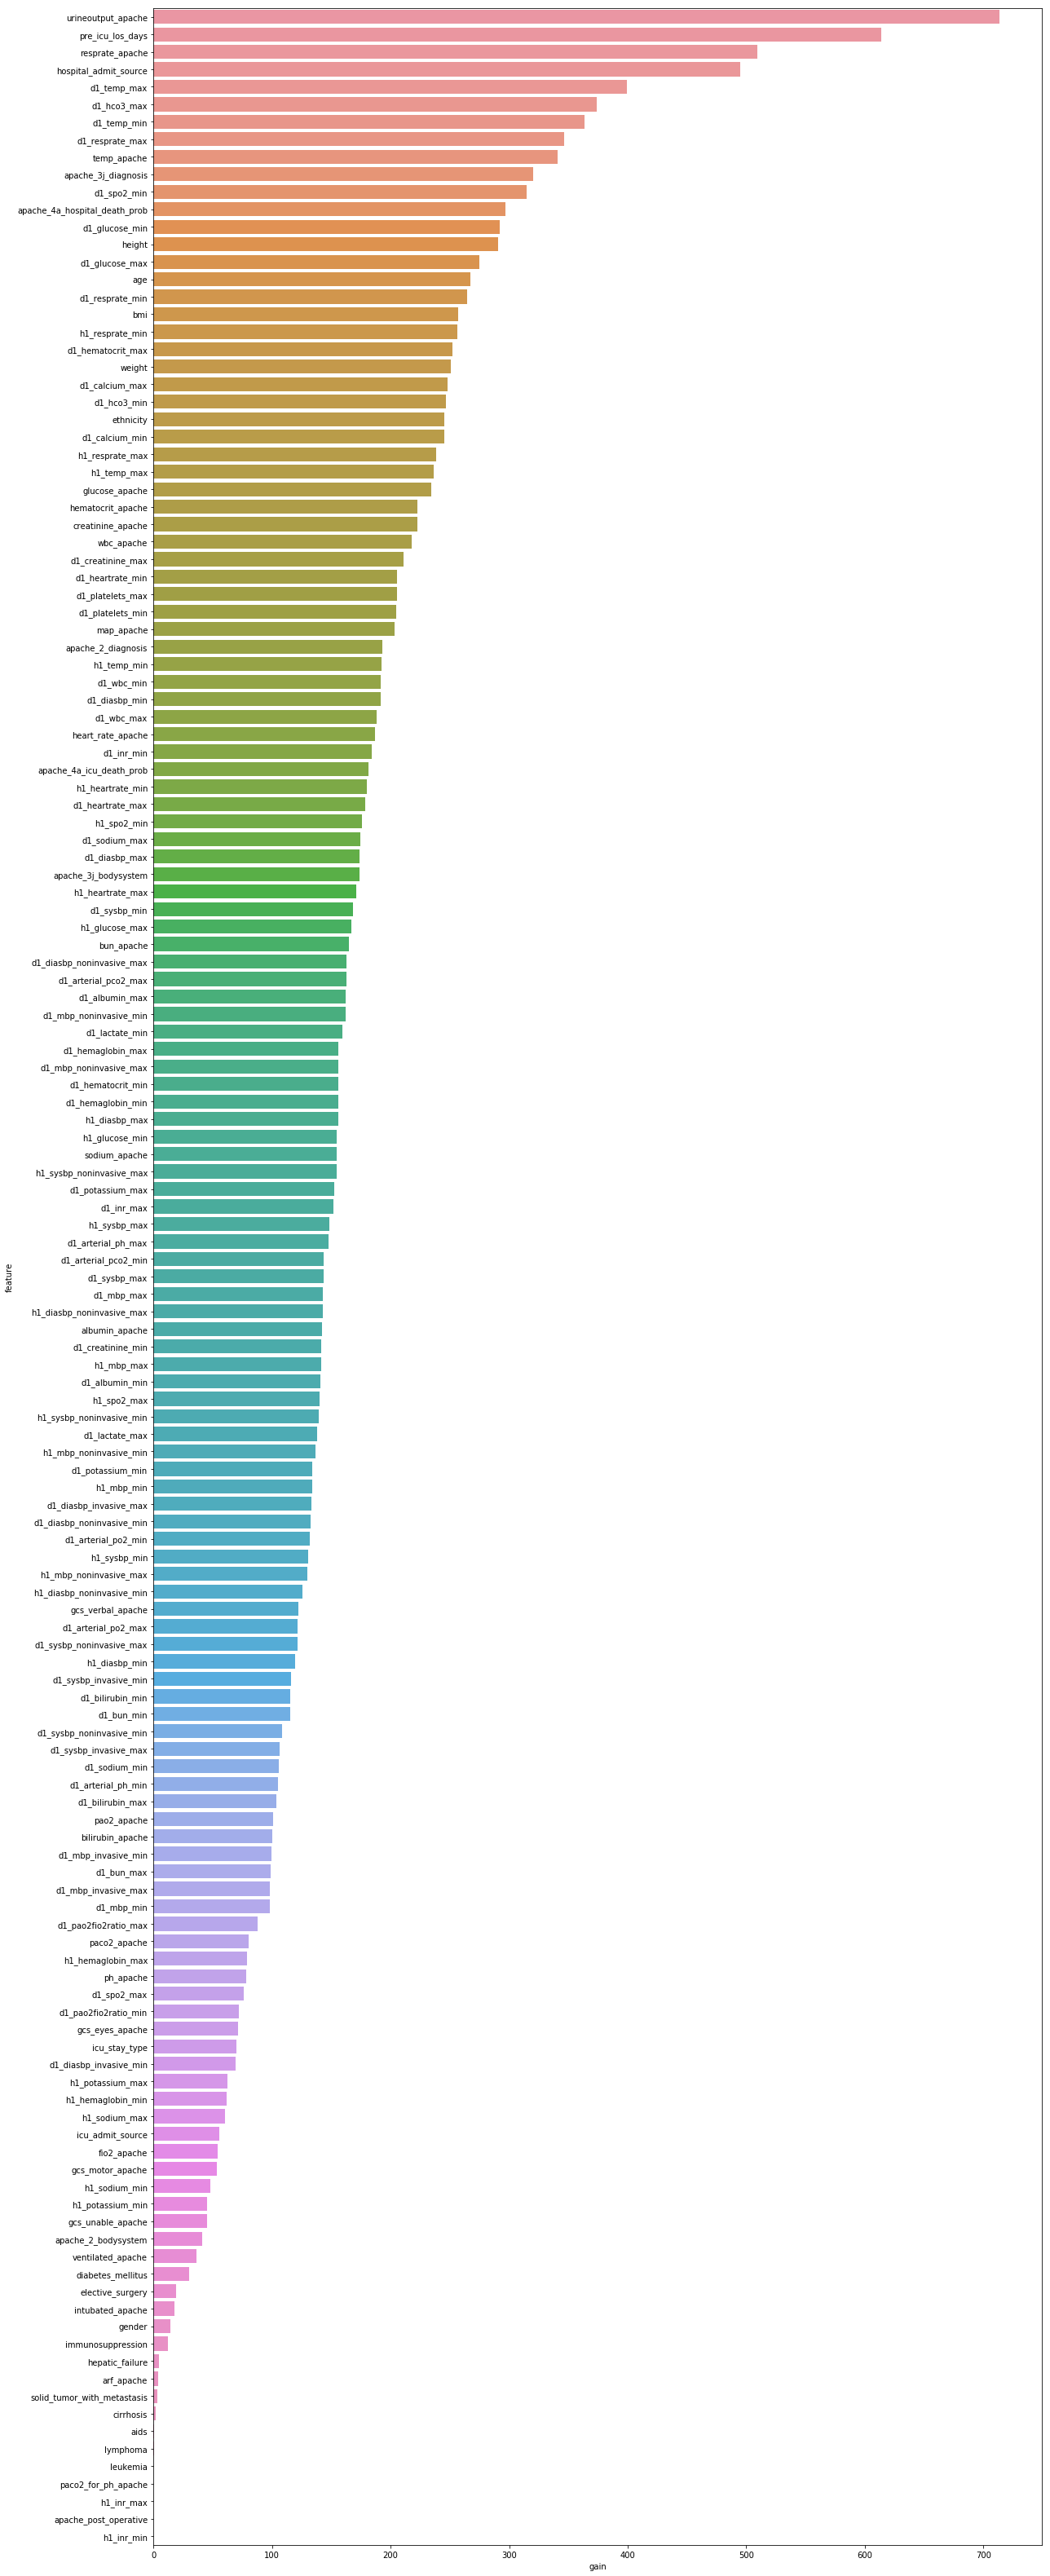

In [23]:
adversarial_features = adversarial_features[['gain', 'feature']].groupby('feature').mean().reset_index()
adversarial_features= adversarial_features.sort_values('gain', ascending=False)
plot_importances(adversarial_features)

urineoutput_apache 0 gain : 713.6


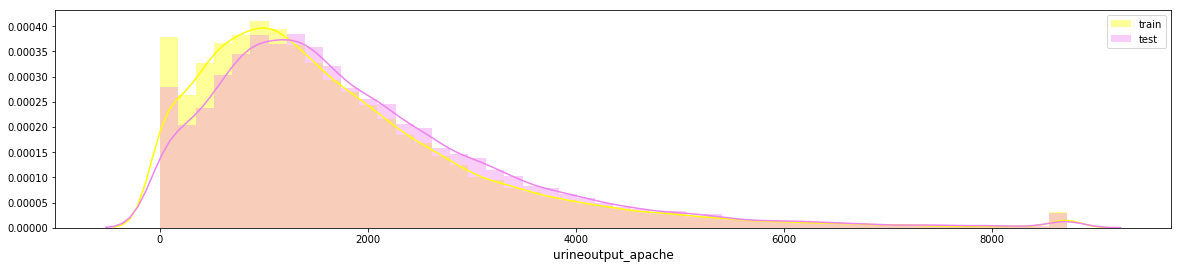

pre_icu_los_days 1 gain : 613.8


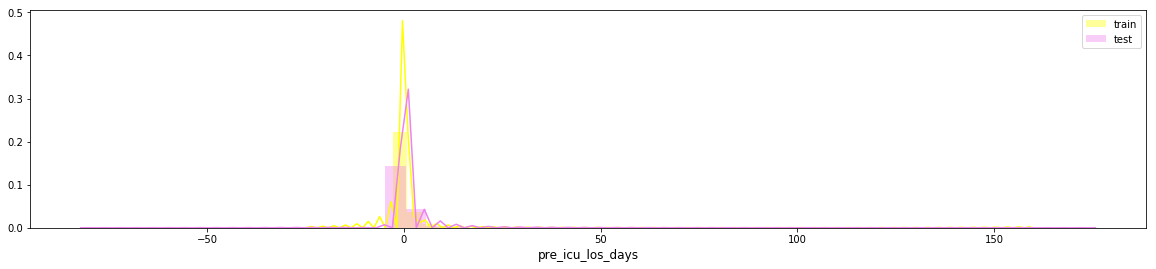

resprate_apache 2 gain : 509.2


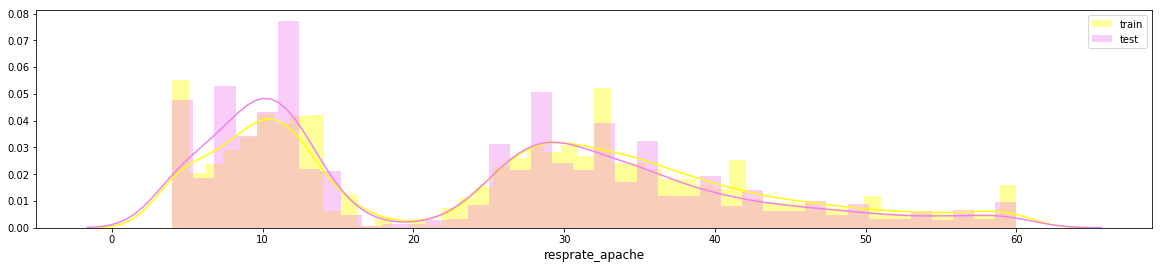

hospital_admit_source 3 gain : 494.6


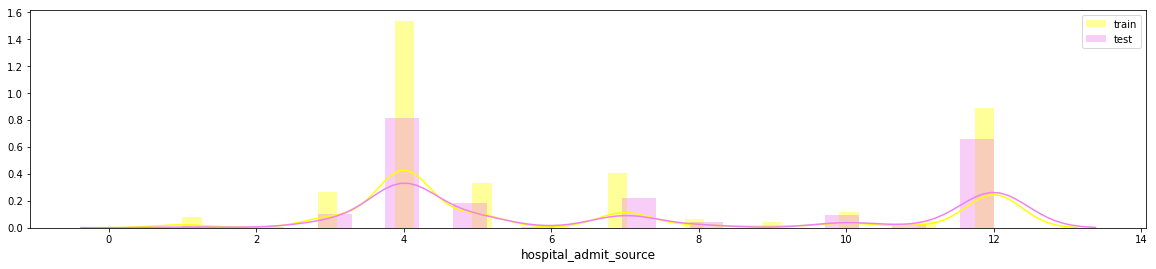

In [24]:
import warnings
warnings.filterwarnings("ignore")
warnings.simplefilter(action='ignore', category=UserWarning)
i=0
for index, row in adversarial_features.sort_values(by=['gain'],ascending=False).iterrows():  
    column=row['feature']
    if i< 4:
            print(column,i,"gain :",row['gain'])
            df1      = train.copy()
            df2      = test.copy()

            fig = plt.figure(figsize=(20,4))
            sns.distplot(df1[column].dropna(),  color='yellow', label='train', kde=True); 
            sns.distplot(df2[column].dropna(),  color='violet', label='test', kde=True); 
            fig=plt.legend(loc='best')
            plt.xlabel(column, fontsize=12);
            plt.show()
            i=i+1

In [28]:
## encounter_id and patient_id are uniqe, should be drop before modeling. Also remove target.
## remove urineoutput_apache and try
to_drop=['encounter_id','patient_id', 'hospital_death','urineoutput_apache','pre_icu_los_days']

## list the categorical features which have string values
categorical_features=['ethnicity','gender','hospital_admit_source','icu_admit_source','icu_stay_type',
                     'apache_3j_bodysystem', 'apache_2_bodysystem']

# list of all input feature we would like the model to use 
features = [col for col in train.columns if col not in to_drop ]
print('numerber of features ' , len(features))

numerber of features  143


In [29]:
if 0: # ACTIVATE it if you want to search for better parameter
    lgb_model = Lgb_Model(train,test, features, categoricals=categorical_features, ps= LGB_BO.max['params']  )
else :
    lgb_model = Lgb_Model(train,test, features, categoricals=categorical_features, ps=params)

Training until validation scores don't improve for 100 rounds.
[100]	training's auc: 0.949132	valid_1's auc: 0.902759
[200]	training's auc: 0.975733	valid_1's auc: 0.902763
Early stopping, best iteration is:
[166]	training's auc: 0.968455	valid_1's auc: 0.903273
Partial score of fold 0 is: 0.9032734061334857
Training until validation scores don't improve for 100 rounds.
[100]	training's auc: 0.949742	valid_1's auc: 0.898776
[200]	training's auc: 0.975237	valid_1's auc: 0.899813
Early stopping, best iteration is:
[163]	training's auc: 0.96819	valid_1's auc: 0.900529
Partial score of fold 1 is: 0.9005291906699614
Training until validation scores don't improve for 100 rounds.
[100]	training's auc: 0.948698	valid_1's auc: 0.903782
[200]	training's auc: 0.974554	valid_1's auc: 0.903471
Early stopping, best iteration is:
[114]	training's auc: 0.953224	valid_1's auc: 0.903884
Partial score of fold 2 is: 0.9038840861359583
Training until validation scores don't improve for 100 rounds.
[100]	tr

In [27]:
## score 0.90880, remove urineoutput_apache
test["hospital_death"] = lgb_model.y_pred
test[["encounter_id","hospital_death"]].to_csv("submission7.csv",index=False)

In [30]:
## score 0.90853, remove urineoutput_apache and pre_icu_los_days
test["hospital_death"] = lgb_model.y_pred
test[["encounter_id","hospital_death"]].to_csv("submission7.csv",index=False)

So there is not necesaary to do adversarial validation to remove any features which may drift between train and test.

Feature Importance from the lightgbm model (gain)

In [31]:
imp_df = pd.DataFrame()
imp_df['feature'] = features
imp_df['gain']  = lgb_model.model.feature_importance(importance_type='gain')
imp_df['split'] = lgb_model.model.feature_importance(importance_type='split')

In [32]:
def plot_importances(importances_):
    mean_gain = importances_[['gain', 'feature']].groupby('feature').mean()
    importances_['mean_gain'] = importances_['feature'].map(mean_gain['gain'])
    plt.figure(figsize=(18, 44))
    data_imp = importances_.sort_values('mean_gain', ascending=False)
    sns.barplot(x='gain', y='feature', data=data_imp[:300])
    plt.tight_layout()
    plt.savefig('importances.png')
    plt.show()

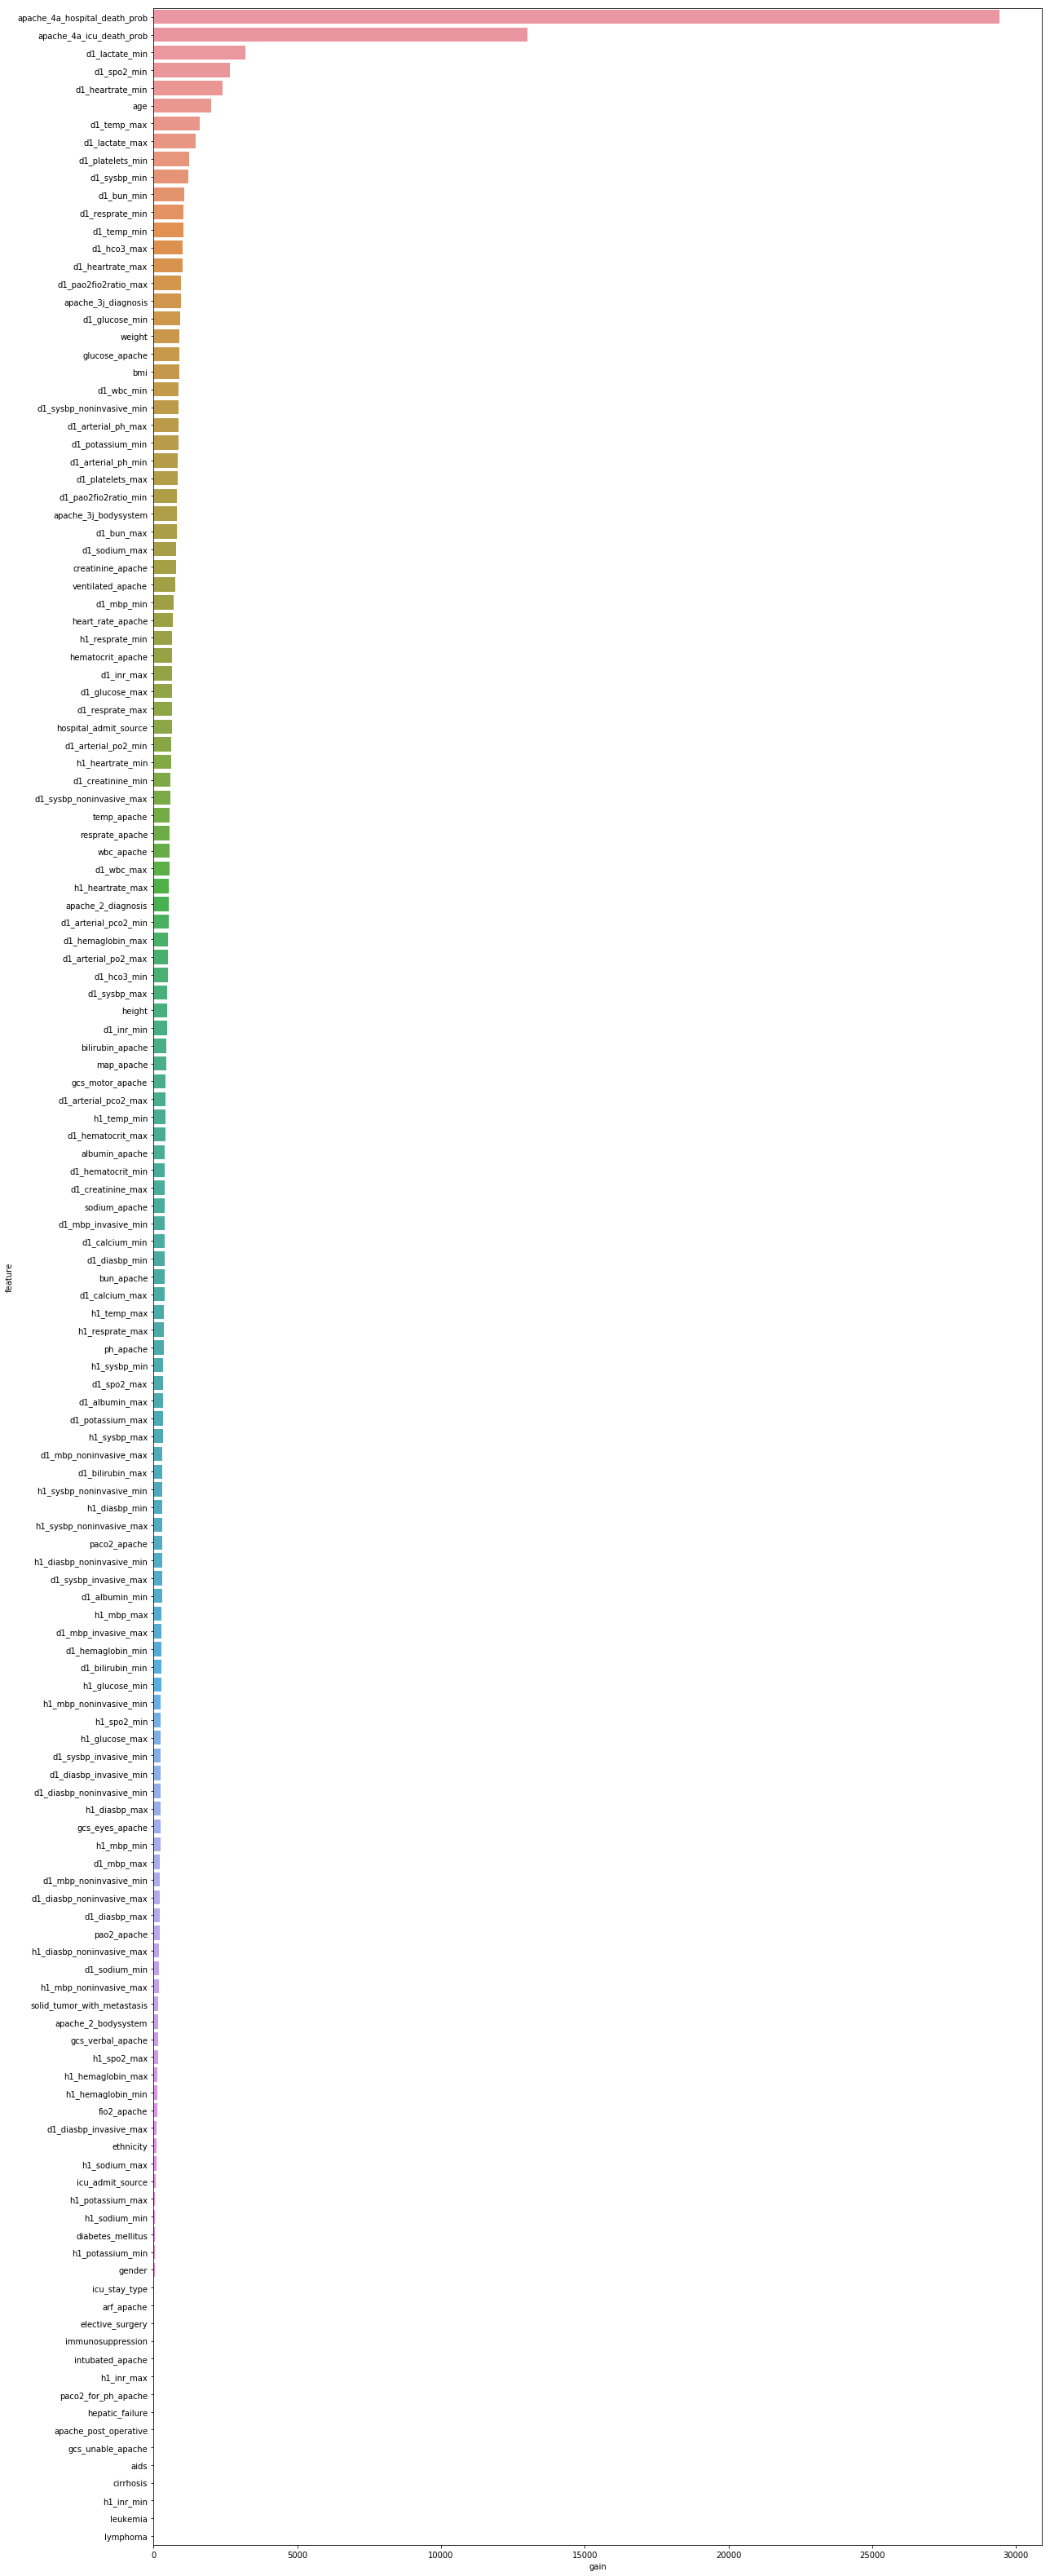

In [33]:
plot_importances(imp_df)

In [47]:
imp_df.shape

(147, 5)